# Imports

In [29]:
import concurrent.futures
import itertools
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import pyarrow as pa
import pyarrow.parquet as pq
import torch
from scipy import stats

In [2]:
DEBUG = "CI" not in os.environ

In [3]:
if DEBUG:
    %load_ext autoreload
    %autoreload 2

In [4]:
import proteinsolver

# Parameters

In [5]:
NOTEBOOK_NAME = "global_analysis_of_protein_folding"

In [6]:
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).resolve()
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_PATH

PosixPath('/home/kimlab1/strokach/working/deep-csp-solver/notebooks/global_analysis_of_protein_folding')

In [7]:
INPUT_PATH = Path(os.getenv("DATAPKG_INPUT_DIR"))
INPUT_PATH

PosixPath('/home/kimlab1/database_data/datapkg_input_dir')

In [8]:
OUTPUT_PATH = Path(os.getenv('OUTPUT_DIR', NOTEBOOK_PATH.name)).resolve()
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH

PosixPath('/home/kimlab1/strokach/working/deep-csp-solver/notebooks/global_analysis_of_protein_folding')

In [9]:
TASK_ID = os.getenv("SLURM_ARRAY_TASK_ID")
TASK_COUNT = os.getenv("ORIGINAL_ARRAY_TASK_COUNT") or os.getenv("SLURM_ARRAY_TASK_COUNT")
NETWORK_NAME = os.getenv("CI_COMMIT_SHA")

TASK_ID = int(TASK_ID) if TASK_ID is not None else None
TASK_COUNT = int(TASK_COUNT) if TASK_COUNT is not None else None

TASK_ID, TASK_COUNT, NETWORK_NAME

(None, None, None)

# Load data

In [10]:
!ls {INPUT_PATH}/global_analysis_of_protein_folding

aan0693_designed-PDB-files	   aan0693_SI_datasets		   hhpred
aan0693_designed-PDB-files.gz.zip  aan0693_SI_datasets.tar.gz.zip  swissmodel


In [11]:
!ls {INPUT_PATH}/global_analysis_of_protein_folding/aan0693_designed-PDB-files

aan0693_designed-PDB-files.gz  other  rd1  rd2	rd3  rd4


In [12]:
!ls {INPUT_PATH}/global_analysis_of_protein_folding/aan0693_SI_datasets

counts_and_ec50s.tar.gz		  protein_and_dna_sequences.tar.gz
design_scripts.tgz		  stability_scores
design_structural_metrics	  stability_scores.tar.gz
design_structural_metrics.tar.gz  unfolded_state_model_params
fig1_thermodynamic_data.csv


## aan0693_SI_datasets

In [13]:
!ls {INPUT_PATH}/global_analysis_of_protein_folding/aan0693_SI_datasets/stability_scores

rd1_stability_scores  rd3_stability_scores  ssm2_stability_scores
rd2_stability_scores  rd4_stability_scores


In [14]:
def remove_controls(df):
    df = df[
        (~df["name"].str.endswith("_hp")) & (~df["name"].str.endswith("_random")) & (~df["name"].str.endswith("_buryD"))
    ]
    return df

In [15]:
def load_stability_scores(key):
    stability_scores = pd.read_csv(
        INPUT_PATH
        / "global_analysis_of_protein_folding"
        / "aan0693_SI_datasets"
        / "stability_scores"
        / f"{key}_stability_scores",
        sep="\t",
    )
    stability_scores = remove_controls(stability_scores)

    for energy_function in ["talaris2013", "betanov15"]:
        rosetta_energies_file = (
            INPUT_PATH
            / "global_analysis_of_protein_folding"
            / "aan0693_SI_datasets"
            / "design_structural_metrics"
            / f"{key}_relax_scored_{'filtered_' if energy_function == 'betanov15' else ''}{energy_function}.sc"
        )
        if not rosetta_energies_file.is_file():
            print(f"Not loading Rosetta energies for {energy_function}!")
            continue

        before_ = len(stability_scores)
        relax_scored_filtered = pd.read_csv(
            rosetta_energies_file, sep="\t" if energy_function == "betanov15" else " +", engine="python"
        ).rename(columns={"description": "name", "total_score": f"{energy_function}_score"})
        stability_scores = stability_scores.merge(
            relax_scored_filtered[["name", f"{energy_function}_score"]], on="name", how="outer"
        )
#         assert len(stability_scores) == before_, (len(stability_scores), before_)

    stability_scores["library_name"] = key
    return stability_scores

### stability_scores

In [39]:
# stability_scores = {}

In [40]:
# for key in ["rd1", "rd2", "rd3", "rd4", "ssm2"]:
#     stability_scores[key] = load_stability_scores(key)

In [41]:
# stability_scores["fig1"] = pd.read_csv(
#     INPUT_PATH / "global_analysis_of_protein_folding" / "aan0693_SI_datasets" / "fig1_thermodynamic_data.csv"
# ).assign(library_name="fig1")

In [ ]:
stability_scores = torch.load(stability_scores, NOTEBOOK_PATH.joinpath("stability_scores.torch"))

# Load network

In [20]:
device = torch.device("cuda:0")
# device = "cpu"

batch_size = 4
num_features = 20
adj_input_size = 2
hidden_size = 128

In [21]:
net = proteinsolver.models.ProteinNet(
    x_input_size=num_features + 1, adj_input_size=adj_input_size, hidden_size=hidden_size, output_size=num_features
)
net.load_state_dict(torch.load("protein_4xEdgeConv_bs4/e12-s1652709-d6610836.state"))
net.eval()
net = net.to(device)

# Structure probabilities

In [22]:
structure_file = "/home/kimlab1/database_data/datapkg_input_dir/global_analysis_of_protein_folding/aan0693_designed-PDB-files/rd1/EEHEE_rd1_0004.pdb"

In [23]:
pdata = proteinsolver.utils.extract_seq_and_adj(structure_file, 'A')

In [24]:
data = proteinsolver.datasets.protein.row_to_data(pdata)
data = proteinsolver.datasets.protein.transform_edge_attr(data)
data.to(device)

proteinsolver.utils.get_node_proba(net, data.x, data.edge_index, data.edge_attr, 20)

tensor([ -3.0604,  -1.5613,  -0.7705,  -3.2686, -12.1462,  -0.7545,  -0.0455,
         -1.8732,  -3.1426,  -6.1099,  -0.9444,  -4.8726,  -5.3841,  -0.7537,
         -3.6710,  -1.3854,  -0.6547,  -0.0167,  -2.9582,  -2.2912,  -2.2548,
         -0.0248,  -3.0484,  -2.8821,  -2.9176,  -0.0973,  -0.7629,  -4.2789,
         -1.2863,  -0.1544,  -1.8983,  -1.8271,  -2.2761,  -3.8315,  -4.4239,
         -1.5960,  -3.9461,  -2.0666,  -3.7369,  -2.0712,  -3.0086],
       device='cuda:0')

## Structure proba

In [173]:
def get_structure_proba(net, filename):
    try:
        library_name = filename.split("_")[1]
    except IndexError:
        return np.nan, np.nan
    filepath = INPUT_PATH / "global_analysis_of_protein_folding" / "aan0693_designed-PDB-files" / library_name / filename
    if not filepath.is_file():
        return np.nan, np.nan
    pdata = proteinsolver.utils.extract_seq_and_adj(filepath, "A")
    data = proteinsolver.datasets.protein.row_to_data(pdata)
    data = proteinsolver.datasets.protein.transform_edge_attr(data)
    data = data.to(device)
#     log_prob = proteinsolver.utils.get_node_proba(net, data.x, data.edge_index, data.edge_attr, 20)
    log_prob = proteinsolver.utils.get_node_value(net, data.x, data.edge_index, data.edge_attr, 20)
    return log_prob.sum().item(), len(pdata.sequence)

In [174]:
for library in ["rd1"]: #, "rd2", "rd3", "rd4"]:
    stability_scores[library]["network_score"], stability_scores[library]["sequence_length"] = np.array(
        [get_structure_proba(net, name) for name in stability_scores[library]["name"]]
    ).T

AttributeError: module 'proteinsolver.utils' has no attribute 'get_node_value'

In [27]:
# for library in ["rd1", "rd2", "rd3", "rd4"]:
#     stability_scores[library]["sum_log_prob"], stability_scores[library]["sequence_length"] = np.array(
#         [get_structure_proba(net, name) for name in stability_scores[library]["name"]]
#     ).T

## Mutation proba

In [127]:
def get_mutation_proba(net, filename, sequence):
    if not filename.endswith(".pdb"):
        filename = filename + ".pdb"

    try:
        library_name = filename.split("_")[1]
        if library_name not in ["rd1", "rd2", "rd3", "rd4"]:
            library_name = "other2"
    except IndexError:
        library_name = "other2"

    filepath = (
        INPUT_PATH / "global_analysis_of_protein_folding" / "aan0693_designed-PDB-files" / library_name / filename
    )
    if not filepath.is_file():
        return np.nan

    chain = "X" if library_name == "other2" else "A"
    pdata = proteinsolver.utils.extract_seq_and_adj(filepath, chain)
    if filename == "villin.pdb":
        pdata = pdata._replace(sequence=pdata.sequence + "SSSGSSGS")
    elif filename == "BBL.pdb":
        pdata = pdata._replace(sequence=pdata.sequence + "N")

    if len(pdata.sequence) != len(sequence):
        print(f"Warning, sequence lengths do not match for protien {filename} ({len(pdata.sequence)}, {len(sequence)})")
        return np.nan
    if sum([a == b for a, b in zip(sequence, pdata.sequence)]) < (len(sequence) * 0.8):
        print(f"Warning, sequence does not match for protien {filename}")
        return np.nan
    pdata = pdata._replace(sequence=sequence)

    data = proteinsolver.datasets.protein.row_to_data(pdata)
    data = proteinsolver.datasets.protein.transform_edge_attr(data)
    data = data.to(device)

    log_prob = proteinsolver.utils.get_node_proba(net, data.x, data.edge_index, data.edge_attr, 20)

    return log_prob.sum().item()

In [132]:
stability_scores["fig1"]["sum_log_prob_mut"] = [
    get_mutation_proba(net, filename.split("_")[0], sequence)
    for filename, sequence in stability_scores["fig1"][["name", "sequence"]].values
]

In [133]:
stability_scores["fig1"]["sum_log_prob_mut"] =stability_scores["sum_log_prob_mut"] 

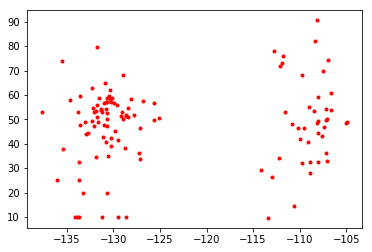

In [134]:
plt.plot(stability_scores["fig1"]["sum_log_prob_mut"], stability_scores["fig1"]["Tm"], 'r.')

In [135]:
plt.plot(stability_scores["fig1"]["base"] = plt.plot(stability_scores["fig1"]["name"].str.split("_").str[0]

SyntaxError: unexpected EOF while parsing (<ipython-input-135-eaefe1e3cebb>, line 1)

In [171]:
results = []

for library in ["rd1", "rd2", "rd3", "rd4"]:
    df = stability_scores[library].dropna(subset=["sum_log_prob", "talaris2013_score", "betanov15_score"]).copy()
    df["domain"] = df["name"].str.split("_").str[0]
    for domain, gp in df.groupby("domain"):
        for score in ["sum_log_prob", "talaris2013_score", "betanov15_score"]:
            corr_t = stats.spearmanr(gp[score], gp["stabilityscore_t"])
            corr_c = stats.spearmanr(gp[score], gp["stabilityscore_c"])
            corr = stats.spearmanr(gp[score], gp[["stabilityscore_t", "stabilityscore_c"]].mean(axis=1))
            results.append((library, domain, score, corr_t[0], corr_t[1], corr_c[0], corr_c[1], corr[0], corr[1]))
            
results_df = pd.DataFrame(results, columns=["library", "domain", "feature", "corr_t", "pvalue_t", "corr_c", "pvalue_c", "corr", "pvalue"])
results_df.head(10)

,library,domain,feature,corr_t,pvalue_t,corr_c,pvalue_c,corr,pvalue
0,rd1,EEHEE,sum_log_prob,0.030808,3.029475e-01,0.037666,2.078186e-01,0.033991,2.556963e-01
1,rd1,EEHEE,talaris2013_score,0.028906,3.338016e-01,0.060923,4.150161e-02,0.060169,4.409240e-02
2,rd1,EEHEE,betanov15_score,-0.001259,9.664265e-01,-0.013897,6.422235e-01,0.000672,9.820769e-01
3,rd1,EHEE,sum_log_prob,0.025937,4.187670e-01,-0.017088,5.942672e-01,0.013600,6.716192e-01
4,rd1,EHEE,talaris2013_score,-0.037468,2.427067e-01,-0.025343,4.294957e-01,-0.057332,7.370457e-02
5,rd1,EHEE,betanov15_score,-0.096413,2.594434e-03,-0.040330,2.085498e-01,-0.076434,1.703971e-02
6,rd1,HEEH,sum_log_prob,0.103036,1.259475e-03,0.054905,8.629492e-02,0.083065,9.389822e-03
7,rd1,HEEH,talaris2013_score,0.036255,2.575741e-01,-0.020517,5.218132e-01,0.010355,7.464883e-01
8,rd1,HEEH,betanov15_score,-0.014816,6.437052e-01,-0.034236,2.850395e-01,-0.025604,4.240486e-01
9,rd1,HHH,sum_log_prob,0.357296,8.621493e-31,0.267449,1.826216e-17,0.346493,6.109146e-29


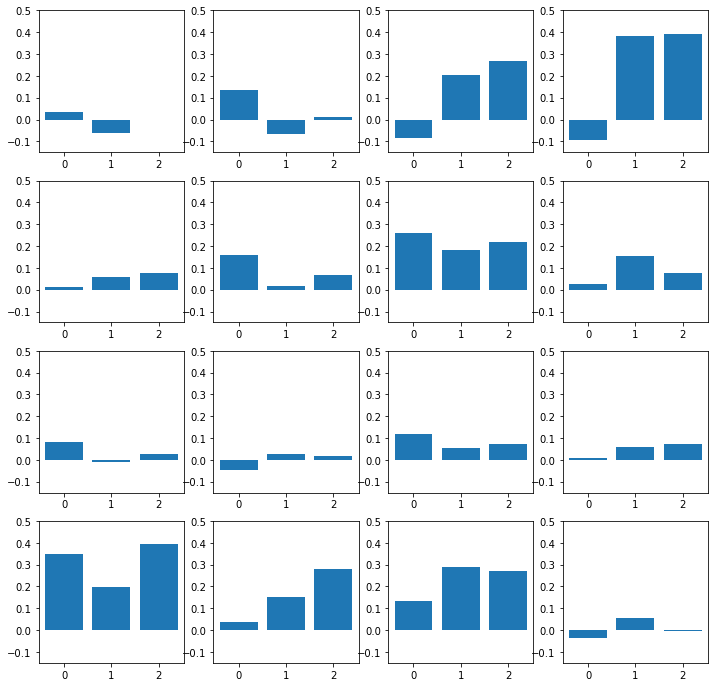

In [172]:
fg, axs = plt.subplots(4, 4, figsize=(12, 12))
for i, domain in enumerate(["EEHEE", "EHEE", "HEEH", "HHH"]):
    for j, library in enumerate(["rd1", "rd2", "rd3", "rd4"]):
        ax = axs[i, j]
        df = results_df[(results_df["domain"] == domain) & (results_df["library"] == library)]
        data = df["corr"].values
        data = [data[0]] + (-data[1:]).tolist()
        ax.bar([0, 1, 2], data)
        ax.set_ylim(-0.15, 0.5)

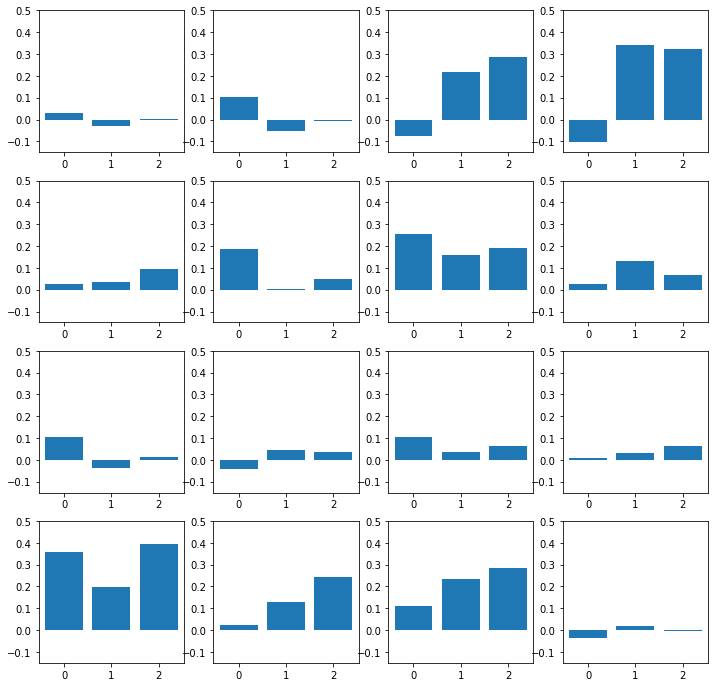

In [169]:
fg, axs = plt.subplots(4, 4, figsize=(12, 12))
for i, domain in enumerate(["EEHEE", "EHEE", "HEEH", "HHH"]):
    for j, library in enumerate(["rd1", "rd2", "rd3", "rd4"]):
        ax = axs[i, j]
        df = results_df[(results_df["domain"] == domain) & (results_df["library"] == library)]
        data = df["corr_t"].values
        data = [data[0]] + (-data[1:]).tolist()
        ax.bar([0, 1, 2], data)
        ax.set_ylim(-0.15, 0.5)

In [71]:
stability_scores["fig1"]

,name,sequence,ref,conditions,Tm,deltaGunf thermal,deltaGunf chemical,ec50_t,ec50_pred_t,ec50_95ci_t,ec50_rise_t,stabilityscore_t,ec50_c,ec50_pred_c,ec50_95ci_c,ec50_rise_c,stabilityscore_c,notes,library_name
0,pin1_wt,MADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGGSNGSGN...,Jager et al 2009,"10 mM NaPi pH 7 15 uM protein, dG computed at 40C",58.6,1.57,NaN,3.93,1.76,0.1,2.17,1.03,3.25,0.55,0.1,2.70,1.29,NaN,fig1
1,pin1_K6A,MADEEALPPGWEKRMSRSSGRVYYFNHITNASQWERPSGGSNGSGN...,Jager et al 2009,"10 mM NaPi pH 7 15 uM protein, dG computed at 40C",59.4,1.72,NaN,4.03,1.76,0.1,2.27,1.08,3.51,0.55,0.2,2.96,1.41,NaN,fig1
2,pin1_L7A,MADEEKAPPGWEKRMSRSSGRVYYFNHITNASQWERPSGGSNGSGN...,Jager et al 2009,"10 mM NaPi pH 7 15 uM protein, dG computed at 40C",37.8,-0.16,NaN,2.99,1.76,0.1,1.23,0.58,2.74,0.54,0.1,2.19,1.05,NaN,fig1
3,pin1_L7I,MADEEKIPPGWEKRMSRSSGRVYYFNHITNASQWERPSGGSNGSGN...,Jager et al 2009,"10 mM NaPi pH 7 15 uM protein, dG computed at 40C",49.3,0.71,NaN,3.10,1.76,0.2,1.34,0.64,2.89,0.54,0.2,2.35,1.12,NaN,fig1
4,pin1_L7V,MADEEKVPPGWEKRMSRSSGRVYYFNHITNASQWERPSGGSNGSGN...,Jager et al 2009,"10 mM NaPi pH 7 15 uM protein, dG computed at 40C",44.0,0.30,NaN,3.00,1.76,0.2,1.24,0.59,2.91,0.54,0.2,2.37,1.13,NaN,fig1
5,pin1_P8A,MADEEKLAPGWEKRMSRSSGRVYYFNHITNASQWERPSGGSNGSGN...,Jager et al 2009,"10 mM NaPi pH 7 15 uM protein, dG computed at 40C",47.4,0.60,NaN,3.55,1.76,0.2,1.80,0.86,2.80,0.54,0.2,2.26,1.08,NaN,fig1
6,pin1_P8G,MADEEKLGPGWEKRMSRSSGRVYYFNHITNASQWERPSGGSNGSGN...,Jager et al 2009,"10 mM NaPi pH 7 15 uM protein, dG computed at 40C",47.7,0.65,NaN,3.02,1.76,0.2,1.26,0.60,3.06,0.55,0.1,2.50,1.19,NaN,fig1
7,pin1_P9A,MADEEKLPAGWEKRMSRSSGRVYYFNHITNASQWERPSGGSNGSGN...,Jager et al 2009,"10 mM NaPi pH 7 15 uM protein, dG computed at 40C",56.0,1.38,NaN,3.94,1.75,0.1,2.19,1.04,3.25,0.21,0.1,3.04,1.45,NaN,fig1
8,pin1_P9G,MADEEKLPGGWEKRMSRSSGRVYYFNHITNASQWERPSGGSNGSGN...,Jager et al 2009,"10 mM NaPi pH 7 15 uM protein, dG computed at 40C",53.1,1.07,NaN,3.97,1.75,0.1,2.21,1.06,3.17,0.28,0.1,2.88,1.38,NaN,fig1
9,pin1_G10A,MADEEKLPPAWEKRMSRSSGRVYYFNHITNASQWERPSGGSNGSGN...,Jager et al 2009,"10 mM NaPi pH 7 15 uM protein, dG computed at 40C",49.0,0.72,NaN,3.64,1.86,0.2,1.78,0.85,3.11,0.49,0.2,2.61,1.25,NaN,fig1


In [70]:
stability_scores["fig1"].iloc[92]

name                                                    BBL_H142W+A130G
sequence              QNNDGLSPAIRRLLAEWNLDASAIKGTGVGGRLTREDVEKHLAKAG...
ref                                                Neuweiler et al 2009
conditions            chem at 283K, thermal 50 mM KPi pH 7 200 mM KC...
Tm                                                                 53.6
deltaGunf thermal                                                  2.73
deltaGunf chemical                                                  NaN
ec50_t                                                             4.05
ec50_pred_t                                                        0.91
ec50_95ci_t                                                         0.1
ec50_rise_t                                                        3.14
stabilityscore_t                                                    1.5
ec50_c                                                              3.3
ec50_pred_c                                                     

In [59]:
stability_scores["fig1"].iloc[92].sequence

'QNNDGLSPAIRRLLAEWNLDASAIKGTGVGGRLTREDVEKHLAKAGGSGN'

In [63]:
stability_scores["fig1"].iloc[93].sequence

'QNNDAASPAIRRLLAEWNLDASAIKGTGVGGRLTREDVEKHLAKAGGSGN'

In [62]:
"QNNDGLSPAIRRLLAEWNLDASAIKGTGVGGRLTREDVEKHLAKAGGSGN"[:141]

'QNNDGLSPAIRRLLAEWNLDASAIKGTGVGGRLTREDVEKHLAKAGGSGN'

In [ ]:
H142W

In [44]:
for library_name in list(stability_scores)[:4]:
    df = stability_scores[library_name][
        (stability_scores[library_name]["sum_log_prob"].isnull())
        & ((stability_scores[library_name]["talaris2013_score"].notnull()))
    ]
    print(library_name, len(df))

rd1 105
rd2 229
rd3 0
rd4 0


In [45]:
for library_name in list(stability_scores)[:4]:
    df = stability_scores[library_name][
        (stability_scores[library_name]["sum_log_prob"].notnull())
        & ((stability_scores[library_name]["talaris2013_score"].isnull()))
    ]
    print(library_name, len(df))

rd1 0
rd2 0
rd3 0
rd4 1552


In [46]:
for library_name in list(stability_scores)[:4]:
    df = stability_scores[library_name][
        ((stability_scores[library_name]["talaris2013_score"].isnull()))
    ]
    print(library_name, len(df))

rd1 0
rd2 0
rd3 41
rd4 6495


In [48]:
def myplot(x, y, ax):
    x, y = pd.DataFrame({'x': x, 'y': y}).dropna().values.T
    corr = stats.spearmanr(x, y)
    ax.plot(x, y, 'r.')
    ax.set_title(f"N: {len(x):,};   Spearman R: {corr[0]:.3f} ({corr[1]:.2f})")

In [49]:
library_name = "rd2"

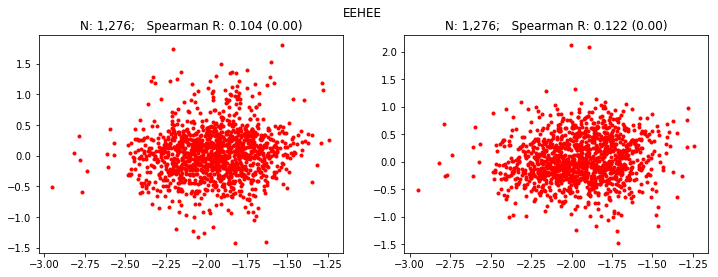

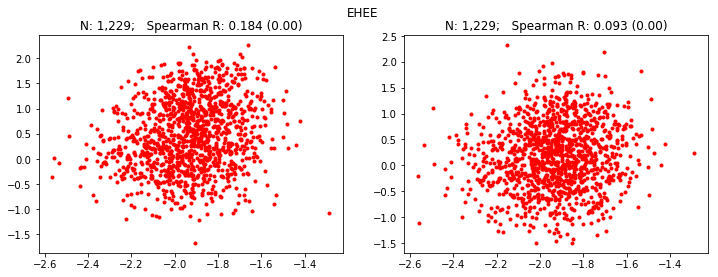

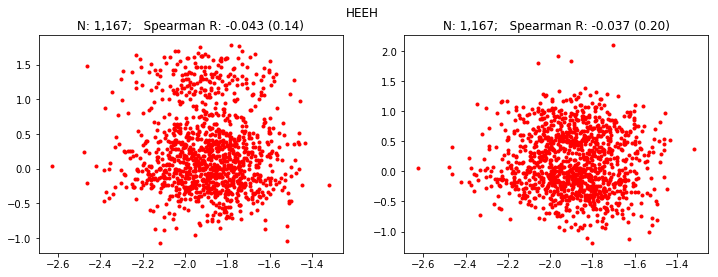

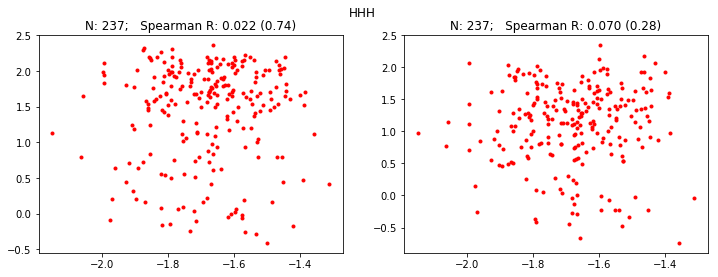

In [50]:
x_col = "sum_log_prob_normed"
df = stability_scores[library_name].copy()
df = df.dropna(subset=["sum_log_prob", "talaris2013_score", "betanov15_score"])
df["domain"] = df["name"].str.split("_").str[0]


for domain, gp in df.groupby("domain"):
    fg, axs = plt.subplots(1, 2, figsize=(12, 4))
    myplot(gp[x_col], gp["stabilityscore_t"], ax=axs[0])
    myplot(gp[x_col], gp["stabilityscore_c"], ax=axs[1])
    fg.suptitle(domain)
    fg.show()

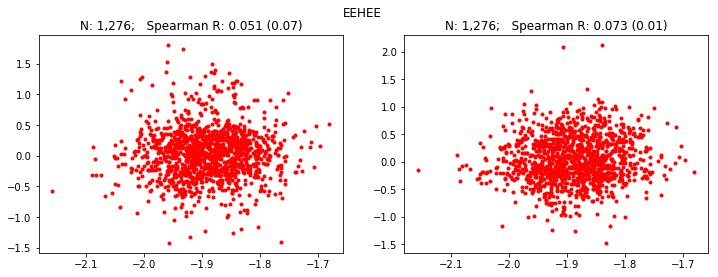

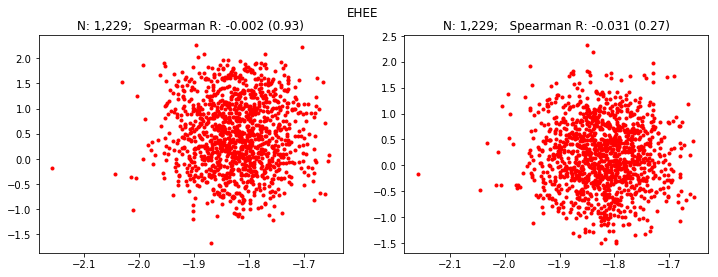

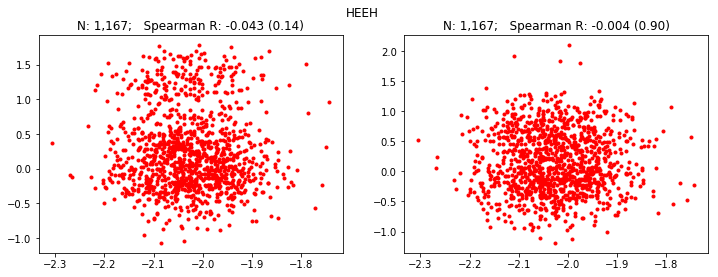

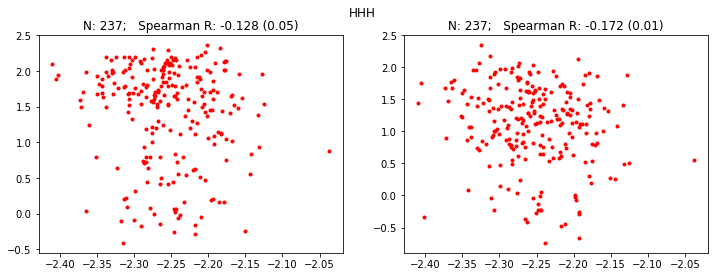

In [53]:
x_col = "talaris2013_score_normed"
df = stability_scores[library_name].copy()
df = df.dropna(subset=["sum_log_prob", "talaris2013_score", "betanov15_score"])
df["domain"] = df["name"].str.split("_").str[0]


for domain, gp in df.groupby("domain"):
    fg, axs = plt.subplots(1, 2, figsize=(12, 4))
    myplot(gp[x_col], gp["stabilityscore_t"], ax=axs[0])
    myplot(gp[x_col], gp["stabilityscore_c"], ax=axs[1])
    fg.suptitle(domain)
    fg.show()

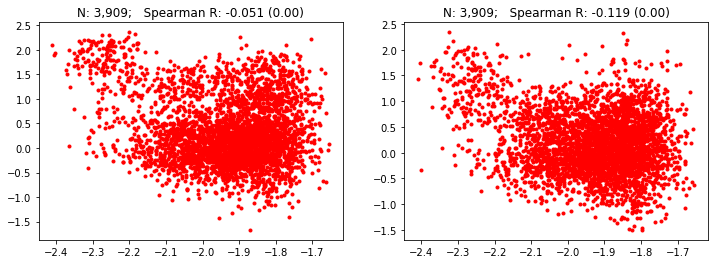

In [52]:
x_col = "talaris2013_score_normed"
df = stability_scores[library_name]
df = df.dropna(subset=["sum_log_prob", "talaris2013_score", "betanov15_score"])

fg, axs = plt.subplots(1, 2, figsize=(12, 4))

myplot(df[x_col], df["stabilityscore_t"], ax=axs[0])
myplot(df[x_col], df["stabilityscore_c"], ax=axs[1])

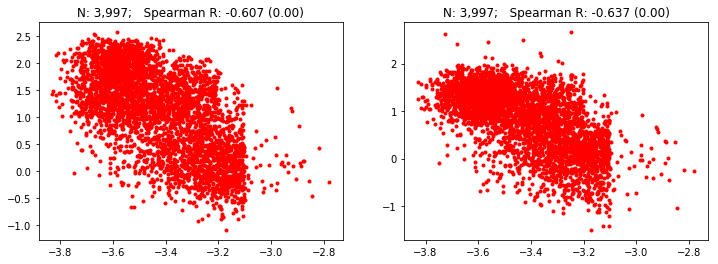

In [467]:
x_col = "betanov15_score_normed"
df = stability_scores[library_name]
df = df.dropna(subset=["sum_log_prob", "talaris2013_score", "betanov15_score"])

fg, axs = plt.subplots(1, 2, figsize=(12, 4))

myplot(df[x_col], df["stabilityscore_t"], ax=axs[0])
myplot(df[x_col], df["stabilityscore_c"], ax=axs[1])

In [ ]:
x_col = "talaris2013_score_normed"
df = stability_scores["rd1"]

fg, axs = plt.subplots(1, 2, figsize=(12, 4))

myplot(stability_scores["rd1"][x_col], stability_scores["rd1"]["stabilityscore_t"], ax=axs[0])
myplot(stability_scores["rd1"][x_col], stability_scores["rd1"]["stabilityscore_c"], ax=axs[1])

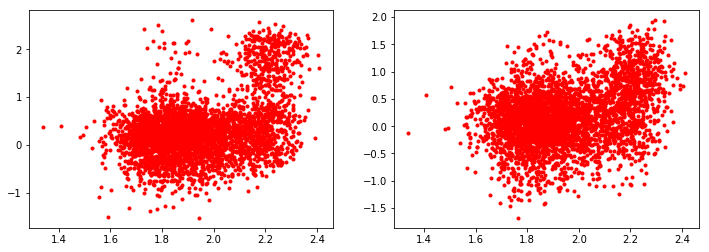

In [68]:
df = stability_scores["rd1"]

fg, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(-df["talaris2013_score"] / df["sequence_lenght"], df["stabilityscore_t"], "r.")
axs[1].plot(-df["talaris2013_score"] / df["sequence_lenght"], df["stabilityscore_c"], "r.")

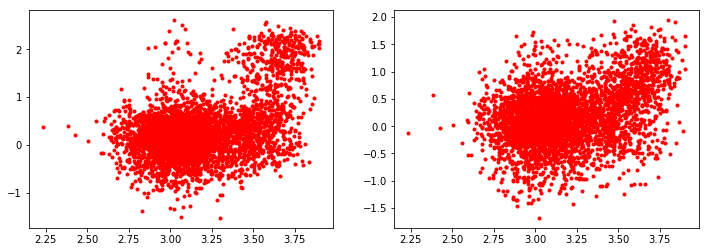

In [67]:
df = stability_scores["rd1"]

fg, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(-df["betanov15_score"] / df["sequence_lenght"], df["stabilityscore_t"], "r.")
axs[1].plot(-df["betanov15_score"] / df["sequence_lenght"], df["stabilityscore_c"], "r.")

In [38]:
get_structure_proba(net, "rd1", "EEHEE_rd1_0001.pdb")

(-83.71563720703125, 41)

In [ ]:
rd3_stability_scores["sequence_lenght"] = [
    get_sequence_length(net, rd3_structure_path / name) for name in rd3_stability_scores["name"]
]

In [ ]:
print(len(rd3_stability_scores))
df = rd3_stability_scores.dropna(how='any').copy()
print(len(df))

stats.spearmanr(df["sum_log_proba"] / df['sequence_lenght'], df["stabilityscore_t"])

In [ ]:
plt.plot(df["sum_log_proba"] / df['sequence_lenght'], df["stabilityscore_t"], 'r.')

In [ ]:
df['type'] = df['name'].str.split("_").str[0]

In [ ]:
for type, gp in df.groupby("type"):
    print(type)
    c = "ec50_rise_t"
    print(stats.spearmanr(gp["sum_log_proba"] / gp['sequence_lenght'], gp[c]))
    plt.plot(gp["sum_log_proba"] / gp['sequence_lenght'], gp[c], 'r.')
    plt.show()